# Automatisierung des Bereitschaftsdienstplans für Einsatzfahrende mithilfe eines Vorhersagemodells

Laden der csv-Datei und erstes Überblick verschaffen

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Laden der CSV-Datei
file_path = 'sickness_table.csv'
df = pd.read_csv(file_path, usecols=lambda column: column not in ['Unnamed: 0'])

# Zeigen der ersten Zeilen der Daten
print("Erste Zeilen der Daten:")
print(df.head())

# Überblick über die Struktur der Daten
print("\nStruktur der Daten:")
print(df.info())

# Statistische Zusammenfassung der Daten
print("\nStatistische Zusammenfassung:")
print(df.describe())

# Prüfen auf fehlende Werte
print("\nFehlende Werte pro Spalte:")
print(df.isnull().sum())

# Umwandlung der Datums-Spalte in datetime-Format mit dayfirst=True
df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')

# Setzen der Datums-Spalte als Index (wenn relevant)
df.set_index('date', inplace=True)

Erste Zeilen der Daten:
         date  n_sick  calls  n_duty  n_sby  sby_need  dafted
0  01/04/2016      73   8154    1700     90         4       0
1  02/04/2016      64   8526    1700     90        70       0
2  03/04/2016      68   8088    1700     90         0       0
3  04/04/2016      71   7044    1700     90         0       0
4  05/04/2016      63   7236    1700     90         0       0

Struktur der Daten:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1152 non-null   object
 1   n_sick    1152 non-null   int64 
 2   calls     1152 non-null   int64 
 3   n_duty    1152 non-null   int64 
 4   n_sby     1152 non-null   int64 
 5   sby_need  1152 non-null   int64 
 6   dafted    1152 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 63.1+ KB
None

Statistische Zusammenfassung:
            n_sick         calls       n_duty   

Zeitreihenplots erstellen um mögliche Saisonalitäten zu erkennen

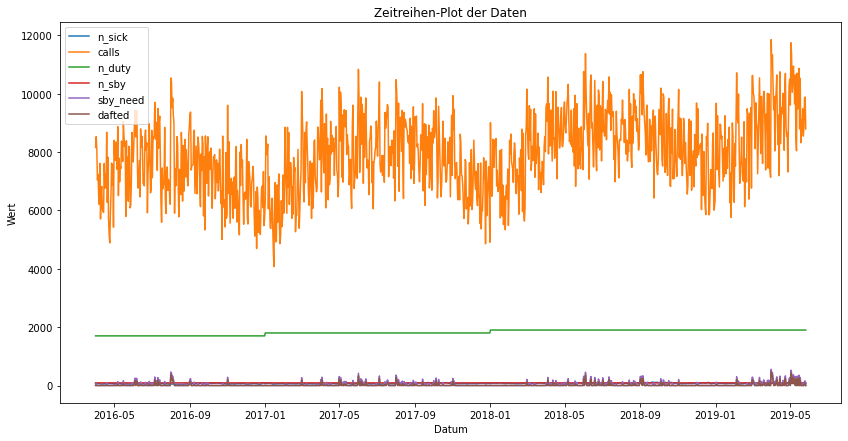

In [2]:
# Zeitreihen-Plot aller Spalten
plt.figure(figsize=(14, 7))
for column in df.columns:
    plt.plot(df.index, df[column], label=column)
plt.title('Zeitreihen-Plot der Daten')
plt.xlabel('Datum')
plt.ylabel('Wert')
plt.legend()
plt.show()

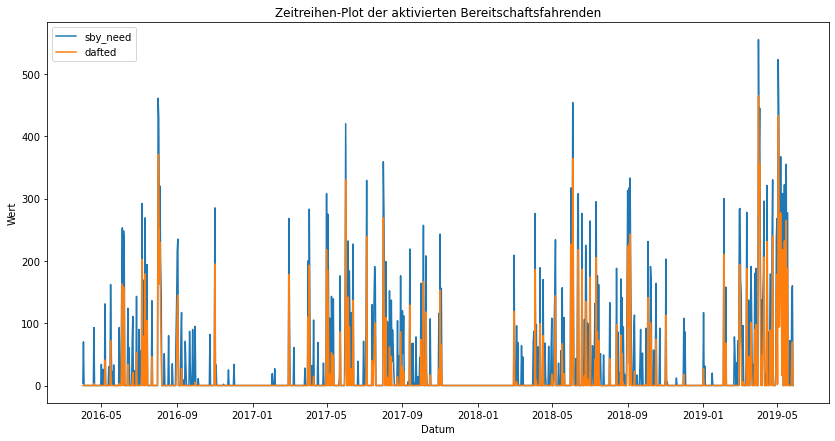

In [3]:
# Zeitreihen-Plot Sby_need
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['sby_need'], label='sby_need')
plt.plot(df.index, df['dafted'],label='dafted')
plt.title('Zeitreihen-Plot der aktivierten Bereitschaftsfahrenden')
plt.xlabel('Datum')
plt.ylabel('Wert')
plt.legend()
plt.show()

Korrelationen zwischen den verschiedenen Merkmalen prüfen

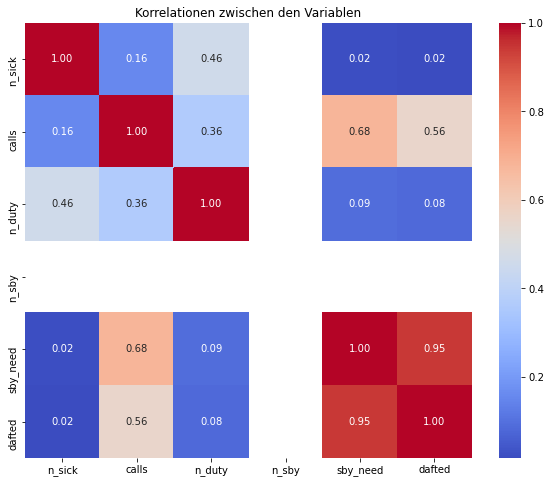

In [4]:
# Heatmap der Korrelationen zwischen den Spalten
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korrelationen zwischen den Variablen')
plt.show()


Verteilungen der Merkmale

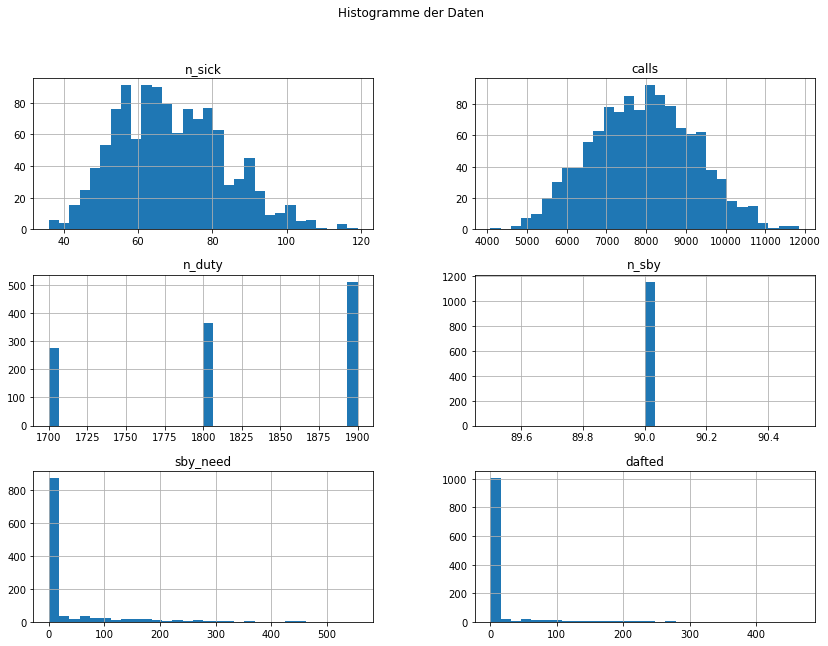

In [5]:
# Historgramme der einzelnen Spalten
df.hist(figsize=(14, 10), bins=30)
plt.suptitle('Histogramme der Daten')
plt.show()

Ausreißer finden

<Figure size 1008x504 with 0 Axes>

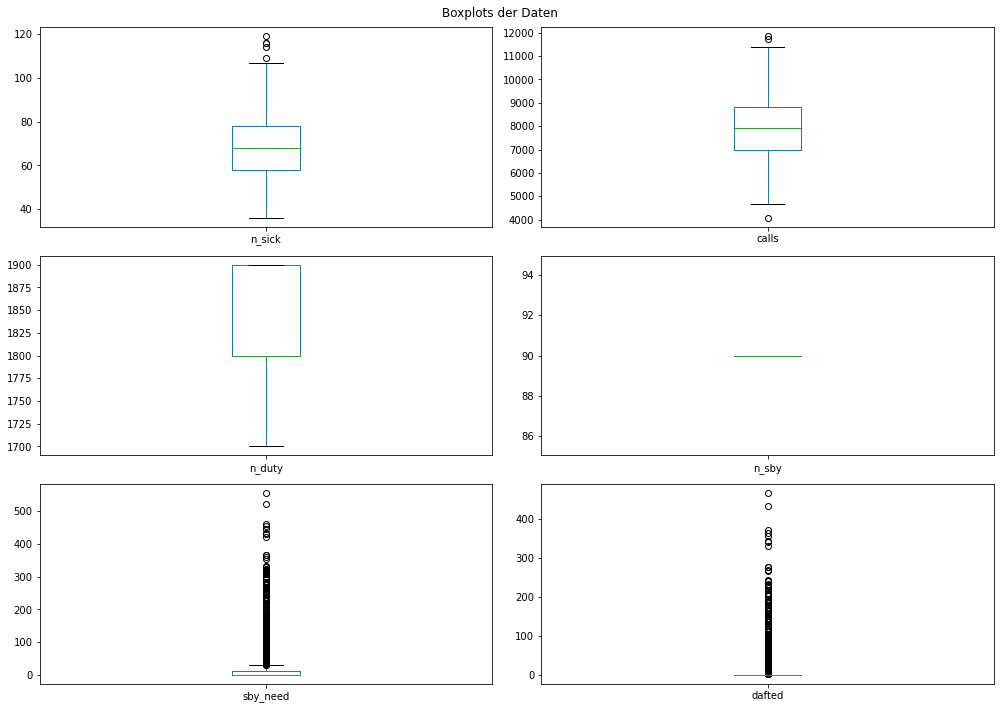

In [6]:
# Boxplots zur Erkennung von Ausreißern
plt.figure(figsize=(14, 7))
df.plot(kind='box', subplots=True, layout=(int(len(df.columns)/2), 2), figsize=(14, 10), title='Boxplots der Daten')
plt.tight_layout()
plt.show()


Prüfen der Fehlermetriken nach Aufgabenstellung

In [7]:
# Anzahl der Tage an denen Nicht-Bereitschaftsfahrende aktiviert werden mussten
# Zeilen mit Werten ungleich 0 in der Spalte "dafted"
count_non_zero_dafted = df[df['dafted'] != 0].shape[0]
print("Anzahl Tage mit Aktivierung nicht Bereitschaftsfahrender: " + str(count_non_zero_dafted))

# Anteilig
print( "Anteilig: " + str(count_non_zero_dafted/df.shape[0]))

Anzahl Tage mit Aktivierung nicht Bereitschaftsfahrender: 171
Anteilig: 0.1484375


Durchschnittlicher prozentualer Anteil der tatsächlich benötigten 
Bereitschaftsfahrenden an den vorgehaltenen Bereitschaftsfahrenden

In [8]:
# Berechnung des durchschnittlichen Anteils von sby_need an n_sby
ratio = (sum(df['sby_need'] -df['dafted'])) / sum(df['n_sby'])

print(ratio)

0.20425347222222223


Ausgabe nach Wochentag

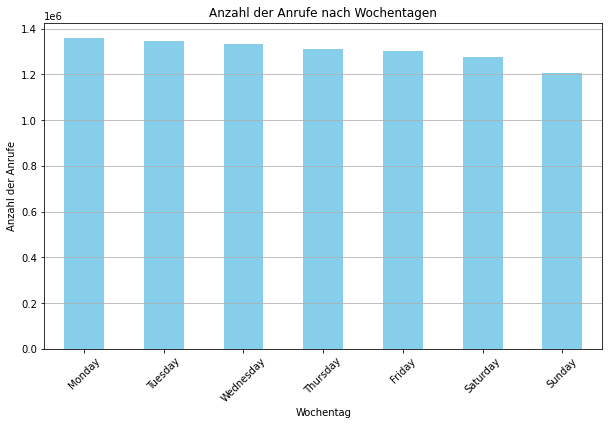

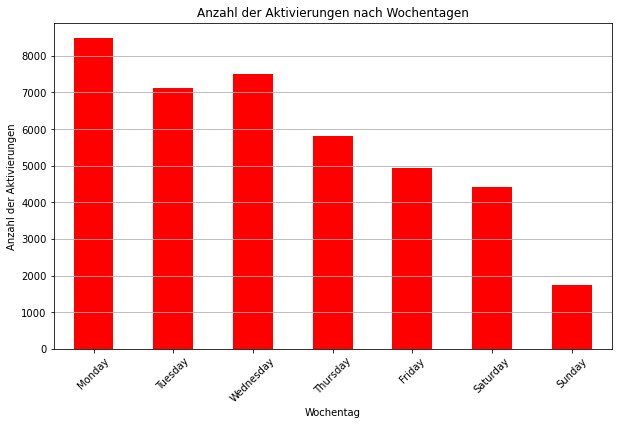

In [9]:

# Extrahieren des Wochentages aus der Datums-Spalte
df['weekday'] = df.index.day_name()

# Gruppierung der Daten nach Wochentagen und Summierung der Anrufe
calls_by_weekday = df.groupby('weekday')['calls'].sum()
sby_by_weekday = df.groupby('weekday')['sby_need'].sum()

# Sortieren der Wochentage in der korrekten Reihenfolge
ordered_weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
calls_by_weekday = calls_by_weekday.reindex(ordered_weekdays)
sby_by_weekday = sby_by_weekday.reindex(ordered_weekdays)

# Erstellen des Plots
plt.figure(figsize=(10, 6))
calls_by_weekday.plot(kind='bar', color='skyblue')
plt.title('Anzahl der Anrufe nach Wochentagen')
plt.xlabel('Wochentag')
plt.ylabel('Anzahl der Anrufe')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Erstellen des Plots
plt.figure(figsize=(10, 6))
sby_by_weekday.plot(kind='bar', color='red')
plt.title('Anzahl der Aktivierungen nach Wochentagen')
plt.xlabel('Wochentag')
plt.ylabel('Anzahl der Aktivierungen')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


Nach Kalendarwoche

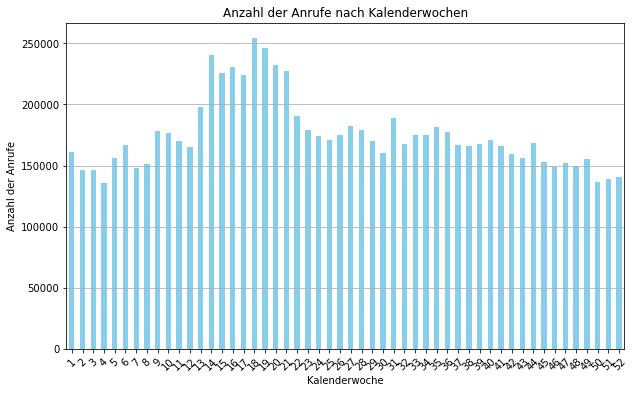

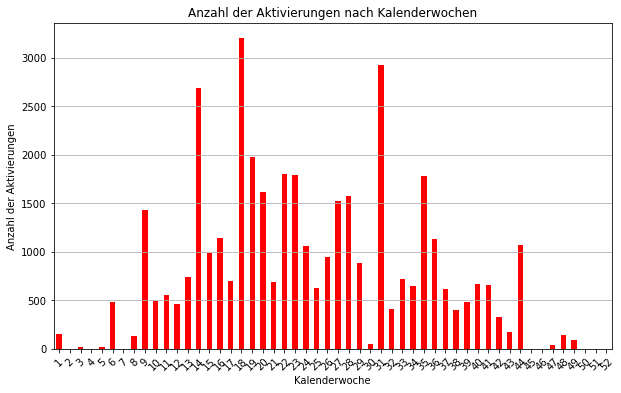

In [10]:
# Extrahieren der Kalenderwoche aus dem Index (Datum)
df['week'] = df.index.isocalendar().week

# Gruppierung der Daten nach Kalenderwochen und Summierung der Anrufe
calls_by_week = df.groupby('week')['calls'].sum()
sby_by_week = df.groupby('week')['sby_need'].sum()

# Erstellen des Plots
plt.figure(figsize=(10, 6))
calls_by_week.plot(kind='bar', color='skyblue')
plt.title('Anzahl der Anrufe nach Kalenderwochen')
plt.xlabel('Kalenderwoche')
plt.ylabel('Anzahl der Anrufe')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Erstellen des Plots
plt.figure(figsize=(10, 6))
sby_by_week.plot(kind='bar', color='red')
plt.title('Anzahl der Aktivierungen nach Kalenderwochen')
plt.xlabel('Kalenderwoche')
plt.ylabel('Anzahl der Aktivierungen')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Nach Monat

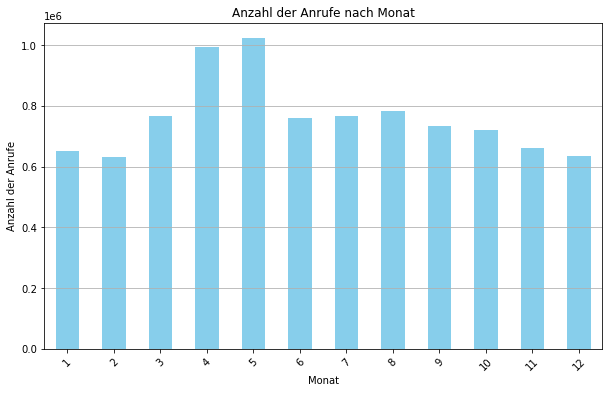

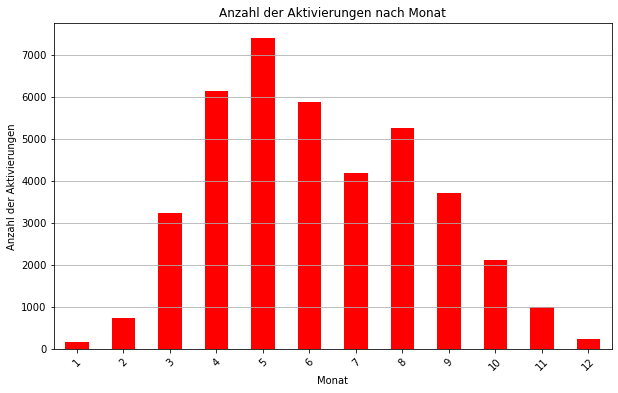

In [11]:
# Extrahieren des Wochentages aus der Datums-Spalte
df['month'] = df.index.month

# Gruppierung der Daten nach Wochentagen und Summierung der Anrufe
calls_by_month= df.groupby('month')['calls'].sum()
sby_by_month= df.groupby('month')['sby_need'].sum()
# Sortieren der Wochentage in der korrekten Reihenfolge
#ordered_weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#calls_by_weekday = calls_by_weekday.reindex(ordered_weekdays)

# Erstellen des Plots
plt.figure(figsize=(10, 6))
calls_by_month.plot(kind='bar', color='skyblue')
plt.title('Anzahl der Anrufe nach Monat')
plt.xlabel('Monat')
plt.ylabel('Anzahl der Anrufe')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Erstellen des Plots
plt.figure(figsize=(10, 6))
sby_by_month.plot(kind='bar', color='red')
plt.title('Anzahl der Aktivierungen nach Monat')
plt.xlabel('Monat')
plt.ylabel('Anzahl der Aktivierungen')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

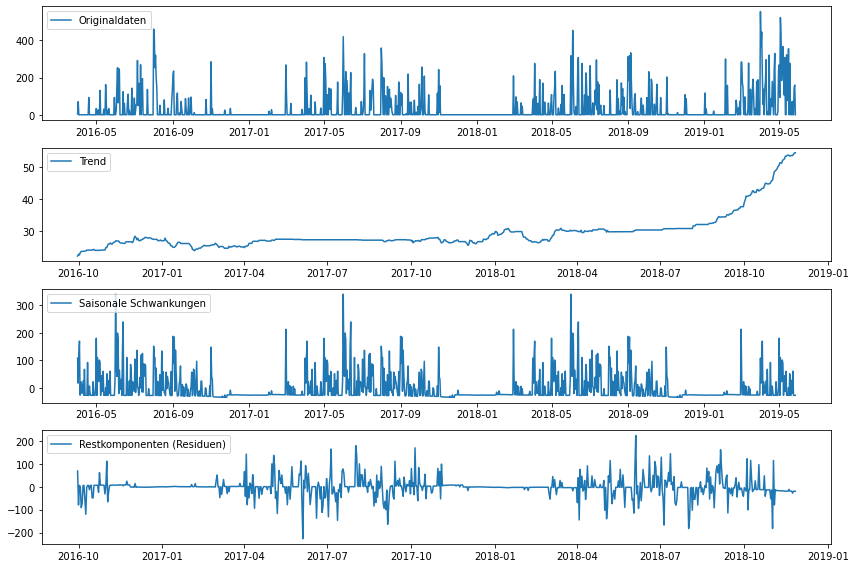

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Zerlegung der Zeitreihe
result = seasonal_decompose(df['sby_need'], model='additive', period=365)  # 'period' anpassen

# Visualisierung der Komponenten
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result.observed, label='Originaldaten')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Saisonale Schwankungen')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Restkomponenten (Residuen)')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

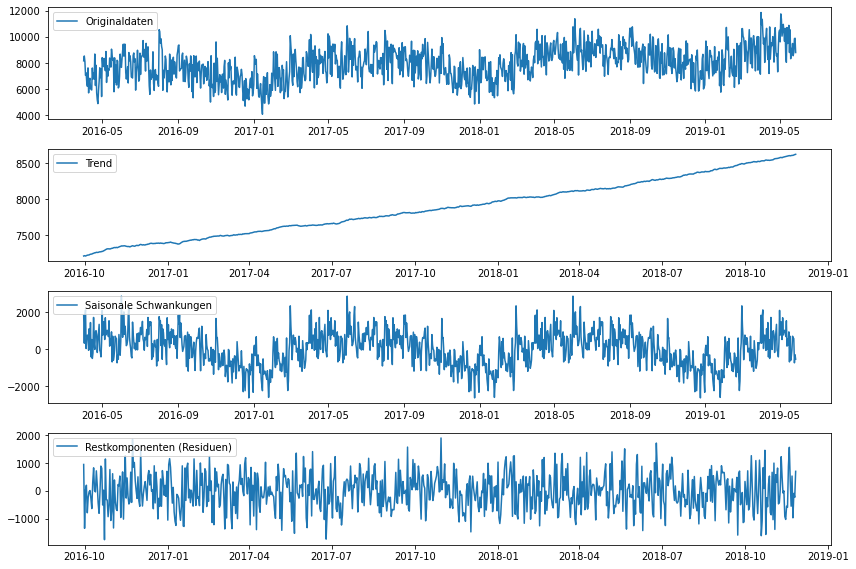

In [13]:
# Zerlegung der Zeitreihe
result = seasonal_decompose(df['calls'], model='additive', period=365)  # 'period' anpassen

# Visualisierung der Komponenten
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result.observed, label='Originaldaten')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Saisonale Schwankungen')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Restkomponenten (Residuen)')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

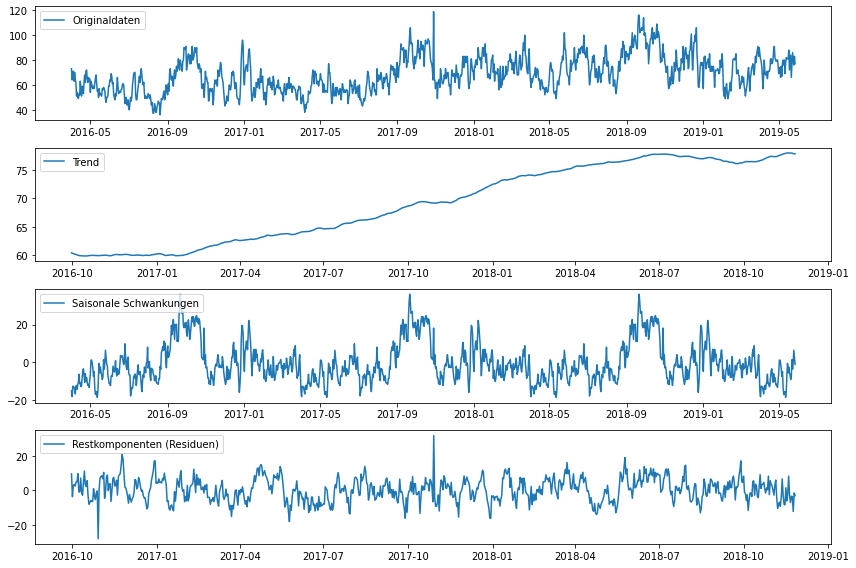

In [14]:
# Zerlegung der Zeitreihe
result = seasonal_decompose(df['n_sick'], model='additive', period=365)  # 'period' anpassen

# Visualisierung der Komponenten
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result.observed, label='Originaldaten')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Saisonale Schwankungen')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Restkomponenten (Residuen)')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

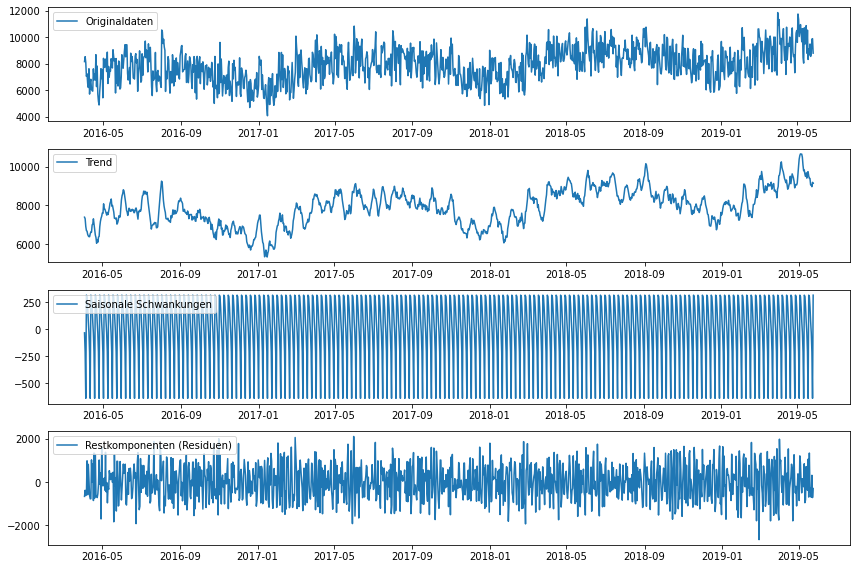

In [15]:
# Zerlegung der Zeitreihe
result = seasonal_decompose(df['calls'], model='additive', period=7)  # 'period' anpassen

# Visualisierung der Komponenten
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result.observed, label='Originaldaten')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Saisonale Schwankungen')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Restkomponenten (Residuen)')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

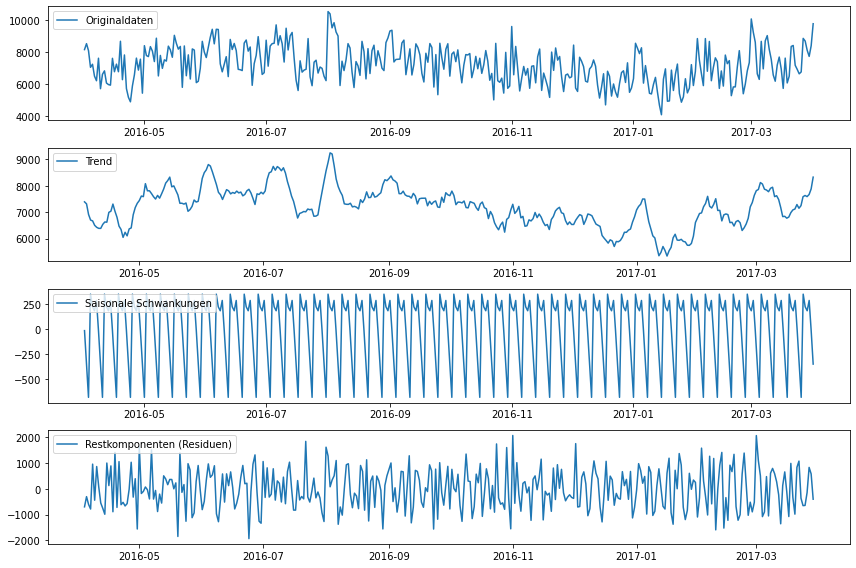

In [16]:
# Bereich für 12 Wochen (84 Tage)
start_date = df.index[0]
end_date = start_date + pd.Timedelta(days=365)

# Filtere die Zeitreihe
df_filtered = df.loc[start_date:end_date]
result_filtered = seasonal_decompose(df_filtered['calls'], model='additive', period=7)

# Visualisierung der Komponenten
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df_filtered.index, df_filtered['calls'], label='Originaldaten')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(df_filtered.index, result_filtered.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(df_filtered.index, result_filtered.seasonal, label='Saisonale Schwankungen')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(df_filtered.index, result_filtered.resid, label='Restkomponenten (Residuen)')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

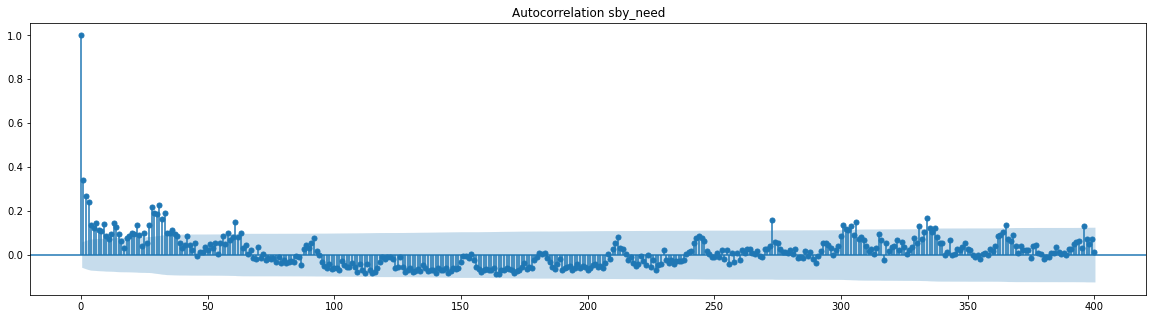

In [24]:
from statsmodels.graphics.tsaplots import plot_acf

# Autokorrelationsplot
fig, ax = plt.subplots(figsize=(20, 5))
plot_acf(df['sby_need'], ax=ax, lags=400)
plt.title('Autocorrelation sby_need')
plt.show()

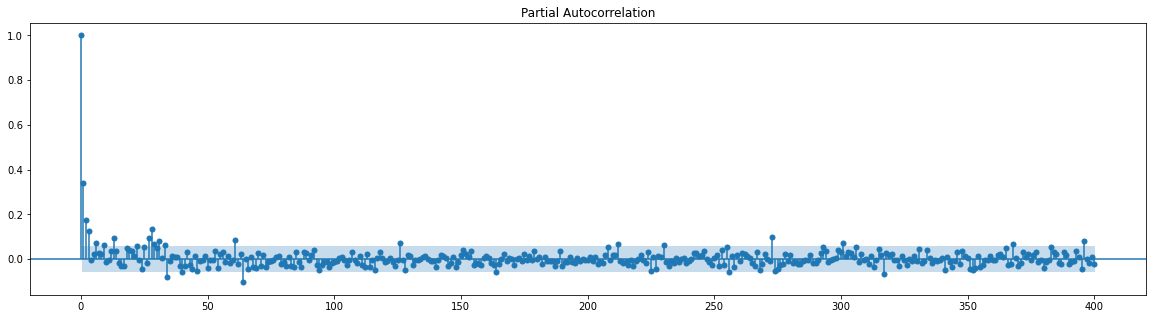

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf
# Erstellen PACF-Plot
fig, ax = plt.subplots(figsize=(20, 5))
plot_pacf(df['sby_need'], ax=ax, lags=400, method='ywm')
plt.show()

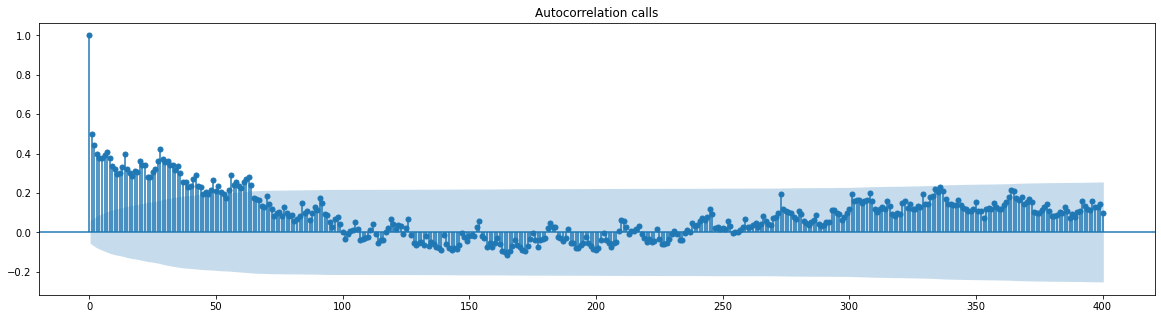

In [25]:
from statsmodels.graphics.tsaplots import plot_acf

# Autokorrelationsplot
fig, ax = plt.subplots(figsize=(20, 5))
plot_acf(df['calls'], ax=ax, lags=400)
plt.title('Autocorrelation calls')
plt.show()

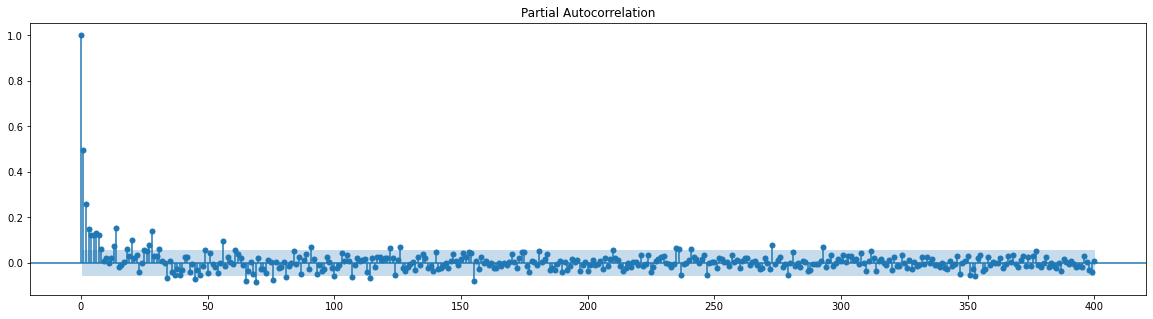

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf
# Erstellen PACF-Plot
fig, ax = plt.subplots(figsize=(20, 5))
plot_pacf(df['calls'], ax=ax, lags=400, method='ywm')
plt.show()

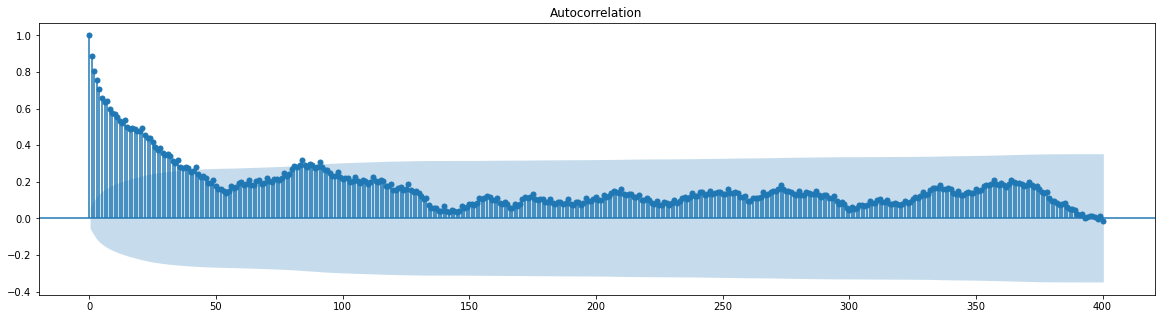

In [21]:
from statsmodels.graphics.tsaplots import plot_acf

# Autokorrelationsplot
fig, ax = plt.subplots(figsize=(20, 5))
plot_acf(df['n_sick'], ax=ax, lags=400)
plt.show()

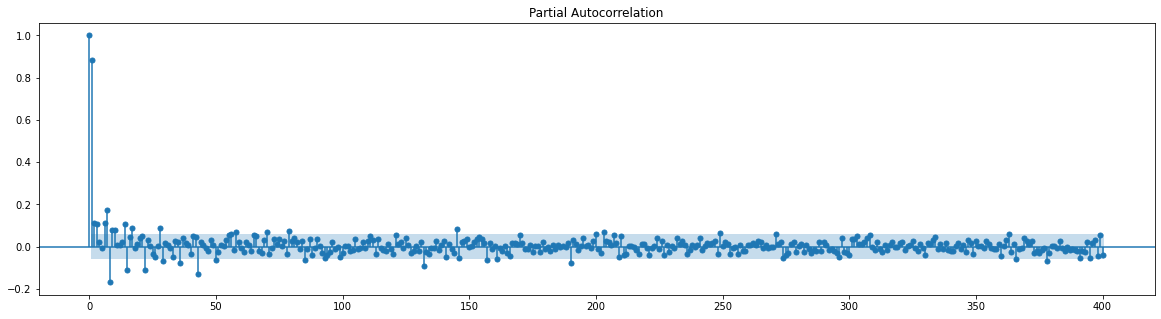

In [22]:
from statsmodels.graphics.tsaplots import plot_pacf
# Erstellen PACF-Plot
fig, ax = plt.subplots(figsize=(20, 5))
plot_pacf(df['n_sick'], ax=ax, lags=400, method='ywm')
plt.show()

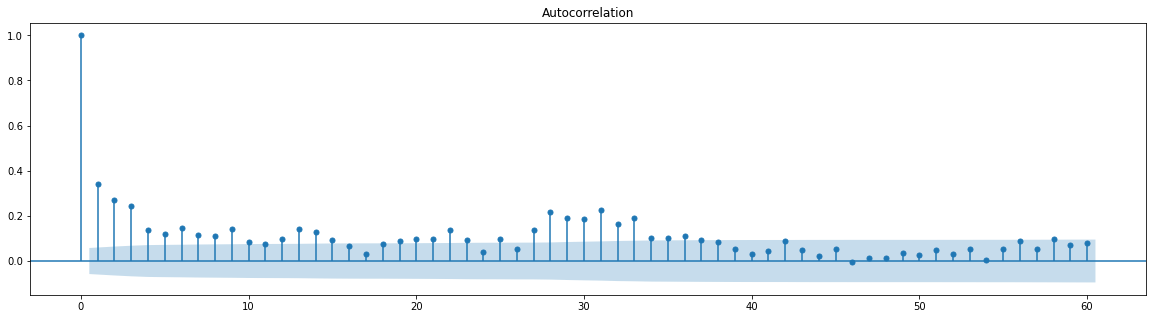

In [23]:
from statsmodels.graphics.tsaplots import plot_acf

# Autokorrelationsplot
fig, ax = plt.subplots(figsize=(20, 5))
plot_acf(df['sby_need'], ax=ax, lags=60)
plt.show()